In [1]:
import os
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from torch.utils.data import Dataset
from PIL import Image
import glob

from torchvision import models
import tqdm
from torchvision.transforms import ToTensor
import time
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.transforms import Resize, Compose, ToPILImage, ToTensor
import pickle
import math
import torchvision.transforms.functional as TF
#from efficientnet_pytorch import EfficientNet

#from kornia.filters import SpatialGradient

import random
from torchvision.transforms import RandomCrop
from SILog import SILogLoss

In [2]:
class MonocularDepthDataset(Dataset):
    def __init__(self, df, in_transform=None,out_transform = None ):
        self.df = df
        self.in_transform = in_transform
        self.out_transform = out_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image']
        depth_path = self.df.iloc[idx]['depth']
        
        sam_path = self.df.iloc[idx]['image']
        sam_path = sam_path.split('/')
        sam_path[0] = 'sam_outputs/mask/'
        sam_path = ''.join(sam_path)
        
        image = Image.open(image_path)
        depth = Image.open(depth_path)
        sam = Image.open(sam_path)
        
        if self.in_transform:
            image = self.in_transform(image)
            sam = self.in_transform(sam)
        if self.out_transform:
            depth = self.out_transform(depth)
        
        #print(image.shape,depth.shape)
        return image, depth, sam

In [3]:


def gradient_loss_fn(gen_frames, gt_frames, alpha=1):
    def gradient(x):
        # idea from tf.image.image_gradients(image)
        # https://github.com/tensorflow/tensorflow/blob/r2.1/tensorflow/python/ops/image_ops_impl.py#L3441-L3512
        # x: (b,c,h,w), float32 or float64
        # dx, dy: (b,c,h,w)

        h_x = x.size()[-2]
        w_x = x.size()[-1]
        # gradient step=1
        left = x
        right = F.pad(x, [0, 1, 0, 0])[:, :, :, 1:]
        top = x
        bottom = F.pad(x, [0, 0, 0, 1])[:, :, 1:, :]

        # dx, dy = torch.abs(right - left), torch.abs(bottom - top)
        dx, dy = right - left, bottom - top 
        # dx will always have zeros in the last column, right-left
        # dy will always have zeros in the last row,    bottom-top
        dx[:, :, :, -1] = 0
        dy[:, :, -1, :] = 0

        return dx, dy

    # gradient
    gen_dx, gen_dy = gradient(gen_frames)
    gt_dx, gt_dy = gradient(gt_frames)
    #
    grad_diff_x = torch.abs(gt_dx - gen_dx)
    grad_diff_y = torch.abs(gt_dy - gen_dy)

    # condense into one tensor and avg
    return torch.mean(grad_diff_x ** alpha + grad_diff_y ** alpha)

class DepthEstimationLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(DepthEstimationLoss, self).__init__()
        self.alpha = alpha


    def forward(self, pred_depth, true_depth):
        pred_depth = torch.clamp(pred_depth, min=1e-8)
        true_depth = torch.clamp(true_depth, min=1e-8)

        # Scale-invariant MSE loss
        diff = torch.log(pred_depth) - torch.log(true_depth)
        mse_loss = torch.mean(diff**2)
        #scale_invariant_mse_loss = mse_loss - (self.alpha * (torch.sum(diff)**2)) / (true_depth.numel()**2)

    

        #gradient_loss = gradient_loss_fn(pred_depth,true_depth,alpha=self.alpha)

        #total_loss = (scale_invariant_mse_loss + gradient_loss)/2

        return mse_loss #this aint right yet

In [4]:
def conv_relu_block(in_channel,out_channel,kernel,padding):
    return nn.Sequential(
            nn.Conv2d(in_channel,out_channel, kernel_size = kernel, padding=padding),
            nn.ReLU()) #nn.ReLU(inplace=True) #nn.Ge

In [5]:
class vanilla_unet_full(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.input_1 = conv_relu_block(3,3,3,1) ##grayscale inputs
        #self.input_2 = conv_relu_block(64, 64, 3, 1) #no extra channels

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.l0 = nn.Sequential(*self.base_layers[:3])
        self.U0_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up0 = conv_relu_block(64 + 256, 128, 3, 0)

        self.l1 = nn.Sequential(*self.base_layers[3:5])
        self.U1_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up1 = conv_relu_block(64 + 256, 256, 3, 1)

        self.l2 = self.base_layers[5]
        self.U2_conv = conv_relu_block(128, 128, 1, 0)
        self.conv_up2 = conv_relu_block(128 + 512, 256, 3, 1)

        self.l3 = self.base_layers[6]
        self.U3_conv = conv_relu_block(256, 256, 1, 0)
        self.conv_up3 = conv_relu_block(256 + 512, 512, 3, 1)

        self.l4 = self.base_layers[7]
        self.U4_conv = conv_relu_block(512, 512, 1, 0)

        self.conv_up4 = conv_relu_block(64 + 128, 64, 3, 1)

        self.out4 = nn.Conv2d(128, n_class, 1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, SAM):
        x = torch.cat([x,SAM,x], axis = 1)
        x = self.input_1(x)
        
        #print(x.shape,'x')
         #concat on channel
        #x_one = self.input_2(x_one)
        block0 = self.l0(x)
        block1 = self.l1(block0)
        block2 = self.l2(block1)
        block3 = self.l3(block2)
        block4 = self.l4(block3)

        block4 = self.U4_conv(block4)
        #print(block4.shape)
        x = nn.Upsample(size = (138,97), mode='bilinear', align_corners=True)(block4)
        block3 = self.U3_conv(block3)
        
        x = torch.cat([x, block3], axis=1)
        x = self.conv_up3(x)
        
        x = nn.Upsample(size = (275,194), mode='bilinear', align_corners=True)(x)
        
        block2 = self.U2_conv(block2)
        
        #print(x.shape, block2.shape)
        x = torch.cat([x, block2], axis=1)
        
        x = self.conv_up2(x)

        x = nn.Upsample(size = (550,388), mode='bilinear', align_corners=True)(x)
        block1 = self.U1_conv(block1)
        #print(x.shape, block1.shape)
        
        x = torch.cat([x, block1], axis=1)
        x = self.conv_up1(x)

        x = nn.Upsample(size = (1100, 775), mode='bilinear', align_corners=True)(x) 
        block0 = self.U0_conv(block0)

        #print(x.shape, block0.shape)
        x = torch.cat([x, block0], axis=1)
        x = self.conv_up0(x)
        out4 = self.out4(x)

        out4_upsampled = F.interpolate(out4, size=(2200,1550), mode='bilinear', align_corners=True)
        
        relu = nn.ReLU()
        out = relu(out4_upsampled)
        
        
        return out4_upsampled


In [6]:
ls

README.md                               evaluaton_utils.py
SILog.py                                inference.py
Uncle_SAM_for_IVC.ipynb                 inference_function_test.ipynb
Untitled.ipynb                          local_evaluation.py
__pycache__/                            my_submission/
aicrowd.json                            requirements.txt
apt.txt                                 submit.sh
depth_training_multichannel_unet.ipynb  train.csv
depth_training_pipeline.ipynb           unet.pt
depth_training_pipeline_jeren.ipynb     unet_full_1epoch.pt
depth_training_vanilla_unet.ipynb       unet_lr001.pt
depth_training_vanilla_unet_full.ipynb  unet_sam.pt
depth_unet_early_exit.ipynb             unet_with_sam.pt
docs/                                   vanilla_unet.png
early_exit_unet.png                     vanilla_unet_lr001.png
early_exit_unet.pt                      vanilla_unet_sam.png
early_exit_unet_sam.png                 vanilla_unet_with_sam.png
early_exit_unet_sam.pt


In [14]:
cd ../../krishna/project

/projectnb/cs585bp/krishna/project


In [20]:
model = vanilla_unet_full(1)
model = nn.DataParallel(model)
model.to('cuda')
state_dict = torch.load('../../nkono/IVC_MDE/unet_sam.pt')

model = model.load_state_dict(state_dict)

In [6]:
v = vanilla_unet_full(5)

/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
x = torch.ones((1,1,2200,1550))

v.forward(x)

TypeError: vanilla_unet_full.forward() missing 1 required positional argument: 'SAM'

In [8]:
#model = depth_model(num_classes=1).to('cuda')
#model = resunet(n_class=1).to('cuda')
model = vanilla_unet_full(n_class=1)
model = nn.DataParallel(model)
model = model.to('cuda')
#model = effunet(n_class=1).to('cuda')

In [9]:
cd ../../krishna/project

/projectnb/cs585bp/krishna/project


In [10]:
pwd

'/projectnb/cs585bp/krishna/project'

In [11]:
# Set hyperparameters, dataset paths, and other configurations
batch_size = 6
learning_rate = 0.001
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#transform = transforms.Compose([
#    transforms.Resize((patch_size, patch_size)),
#    transforms.ToTensor()
#])
#transform = None
OUT_SIZE = (2200, 1550)
in_transform = transforms.Compose([
    transforms.Resize((2200, 1550)),
    transforms.ToTensor()
])

out_transform = transforms.Compose([
    transforms.Resize(OUT_SIZE),
    transforms.ToTensor()
])

df = pd.read_csv('train.csv')
#train_dataset = MonocularDepthDataset(df, transform = transform)
#val_dataset = MonocularDepthDataset(val_image_paths, val_depth_paths, transform)

train_dataset = MonocularDepthDataset(df, in_transform = in_transform, out_transform = out_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


criterion = SILogLoss()#DepthEstimationLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for epoch in tqdm.tqdm_notebook(range(num_epochs)):
    #train_loss = train(model, train_dataloader, optimizer, criterion, device)
    
    model.train()
    running_loss = 0.0
    
    for images, depths, sam_outputs in tqdm.tqdm_notebook(train_dataloader):
        #print(type(images))
        images = images.to(device)
        depths = depths.to(device)
        
        #sam_outputs = images.detach().clone().to(device)
        #mask = depths == 0
        #f_img = (depths - 1)/128.0
        #f_img[mask] = 0
        #depths = f_img.float()
        
        
        #depths /= 10587

        optimizer.zero_grad()

        outputs = model(images, sam_outputs)
        #print(outputs[-1].shape, ',',depths.shape)
        loss = criterion(outputs.float(), depths.float())
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_dataloader)
    print(f'Currrent loss for epoch {epoch} ', train_loss)
    losses.append(train_loss)
    #val_loss = validate(model, val_dataloader, criterion, device)

/scratch/7313154.1.academic-gpu/ipykernel_134424/1621252127.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/10 [00:00<?, ?it/s]

/scratch/7313154.1.academic-gpu/ipykernel_134424/1621252127.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for images, depths, sam_outputs in tqdm.tqdm_notebook(train_dataloader):


  0%|          | 0/298 [00:00<?, ?it/s]

Currrent loss for epoch 0  84.18806772424071


  0%|          | 0/298 [00:00<?, ?it/s]

Currrent loss for epoch 1  84.53689703205288


  0%|          | 0/298 [00:00<?, ?it/s]

Currrent loss for epoch 2  84.23159622345995


  0%|          | 0/298 [00:00<?, ?it/s]

Currrent loss for epoch 3  84.48194914696201


  0%|          | 0/298 [00:00<?, ?it/s]

Currrent loss for epoch 4  84.49908851777147


  0%|          | 0/298 [00:00<?, ?it/s]

Currrent loss for epoch 5  84.2917090934395


  0%|          | 0/298 [00:00<?, ?it/s]

Currrent loss for epoch 6  84.58244600232015


  0%|          | 0/298 [00:00<?, ?it/s]

Currrent loss for epoch 7  84.02224570152744


  0%|          | 0/298 [00:00<?, ?it/s]

Currrent loss for epoch 8  83.98925357536982


  0%|          | 0/298 [00:00<?, ?it/s]

Currrent loss for epoch 9  84.16373444883615


In [12]:
cd ../../nkono/IVC_MDE

/projectnb/cs585bp/nkono/IVC_MDE


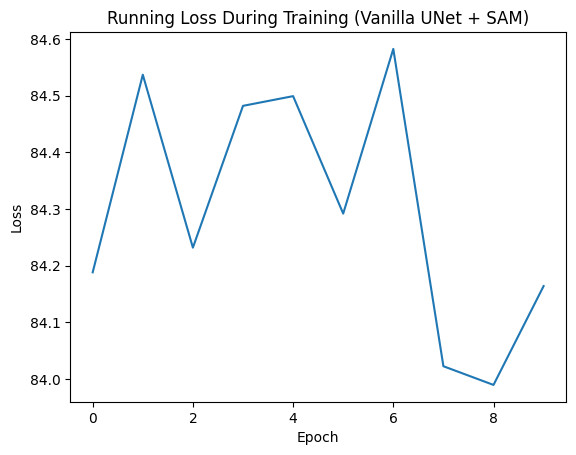

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Running Loss During Training (Vanilla UNet + SAM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.savefig('vanilla_unet_sam.png')
torch.save(model.state_dict(), 'unet_sam.pt')

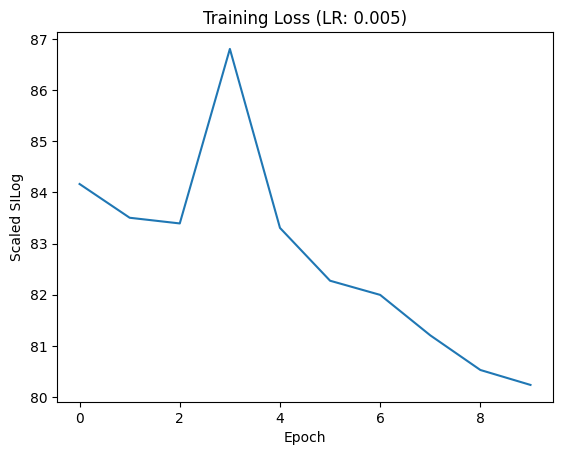

In [15]:
epochs = [84.16497007792428,83.5048999786377,83.39378698720228, 86.8058697745304, 83.30677667400181
, 82.27385287956903, 81.99679324130884,
          81.20592520540993,80.52857478353,80.23664299113638]
import matplotlib.pyplot as plt
plt.plot(epochs)
plt.xlabel('Epoch')
plt.ylabel('Scaled SILog')
plt.title('Training Loss (LR: 0.005)')
plt.show()

In [11]:
torch.save(model, 'unet_full_1epoch.pt')

In [46]:
from inference import prediction, display_depth_image

In [56]:
import inference
from importlib import reload
reload(inference)

<module 'inference' from '/projectnb/cs585bp/nkono/IVC_MDE/inference.py'>

torch.Size([4, 1, 2200, 1550])
torch.Size([4, 1, 2200, 1550])
torch.Size([1, 1, 2200, 1550])


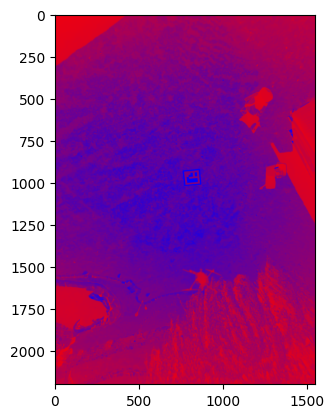

In [58]:
# Need a 4 dimensional thing
print(depths.shape)
print(images.shape)
# Choose the last image
sample_input = images[-1, :, :, :].view(1, 1, images.shape[2], images.shape[3])
sample_input = sample_input.to(device)

print(sample_input.shape)

seg_img = inference.prediction(model, sample_input, device=device)
tout = inference.display_depth_image(seg_img.cpu())